In [49]:
import os
import numpy as np
from PIL import Image, ImageFilter
from functools import partial

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torchvision.transforms.functional as TF
from torchvision import models
from torch.nn import Module, Conv2d, Parameter, Softmax
from torchvision.transforms import v2

import matplotlib
import matplotlib.pyplot as plt

import datetime
from tqdm import tqdm
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from models import MAResUNet, UNet
from dataset import RoadSegmentationDataset, standardize
from metrics import compute_metrics, compute_f1_score
from training_functions import train_epoch, validate, get_predictions

In [42]:
#### Defines path for data ####

data_path="../data/training"
train_path= data_path + "/images"
label_path= data_path + "/groundtruth"

image_path_list=os.listdir(train_path)
image_path=os.path.join(train_path, image_path_list[0])
label_pt=os.path.join(label_path, image_path_list[0])


image = Image.open(image_path)
label = Image.open(label_pt)

image_array = np.array(image)
label_array = np.array(label)
#### Crashes on regular notebooks ####

# fig, ax= plt.subplots(1,2)
# ax[0].imshow(image_array)
# ax[1].imshow(label_array)

In [43]:
#### Data augmentation using albumentations library ####

trans=A.Compose(
        [A.Rotate(limit=70, p=1.0),
         A.VerticalFlip(p=0.1),
         A.HorizontalFlip(p=0.5),
         A.RandomSizedCrop(min_max_height=(200,200), height = 400, width = 400, p=0.1),
         A.RandomBrightnessContrast(p=0.2),
         ToTensorV2()
        ])

transform_x = standardize
trans_non_augmented = ToTensorV2()

In [44]:
#### Data loader ####

def get_dataloaders(batch_size, show_examples=False):

    dataset_augmented = RoadSegmentationDataset(data_dir=data_path, transform=trans, transform_x=transform_x)
    dataset_non_augmented = RoadSegmentationDataset(data_dir=data_path, transform=trans_non_augmented, transform_x=transform_x)
    dataset = ConcatDataset([dataset_augmented, dataset_non_augmented])
    #dataset = dataset_non_augmented
    val_percent=0.15
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))



    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,  # Shuffle the iteration order over the dataset
        pin_memory=torch.cuda.is_available(),
        drop_last=False,
        num_workers=2,
    )

    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
    )

    if show_examples:
      for batch in train_loader:
          images = batch[0]  # Assuming your batch has a key 'image'
          masks = batch[1]    # Assuming your batch has a key 'mask'

          # Assuming images and masks are 4D tensors (batch_size, channels, height, width)
          image = images[0]
          mask = masks[0]
          #print(images.shape)
          #print(image.shape)
          # Convert tensors to NumPy arrays
          image_np = image.numpy()
          mask_np = mask.squeeze().numpy()  # Assuming mask is single-channel

          # Plot the image
          plt.figure(figsize=(8, 4))

          plt.subplot(1, 2, 1)
          plt.imshow(np.transpose(image_np, (1, 2, 0)))
          plt.title('Image')
          plt.axis('off')

          # Plot the mask
          plt.subplot(1, 2, 2)
          plt.imshow(mask_np, cmap='gray')  # Adjust cmap based on your mask
          plt.title('Mask')
          plt.axis('off')

          plt.show()

          # Break after the first batch
          break
    return train_loader, val_loader


#### set show_examples to True if you want samples ####

temp = get_dataloaders(
    batch_size=32,
    show_examples=False,
)
del temp

In [51]:
def compute_metrics(target, predicted_probs, threshold=0.5):
    """
    Compute accuracy and F1 score for binary segmentation.

    Parameters:
        target (torch.Tensor): Ground truth binary mask tensor of size [1, 1, H, W].
        predicted_probs (torch.Tensor): Predicted probability map tensor of size [1, 1, H, W].
        threshold (float): Threshold for binarizing the predicted probability map.

    Returns:
        accuracy (float): Accuracy score.
        f1 (float): F1 score.
    """
    # Binarize the predicted probabilities
    predicted_binary = (predicted_probs > threshold).float()

    target_flat = target.view(-1)
    predicted_flat = predicted_binary.view(-1)

    correct_predictions = (target_flat == predicted_flat).float()
    accuracy = correct_predictions.mean().item()
    
    return np.round(accuracy,3)

def compute_f1_score(target_masks, predicted_masks, threshold=0.5):
    """
    Compute F1 score for a batch of target and predicted masks.

    Args:
    - target_masks (torch.Tensor): Batch of target masks (ground truth).
    - predicted_masks (torch.Tensor): Batch of predicted masks.
    - threshold (float): Threshold for binarizing the predicted masks.

    Returns:
    - f1_score (float): Computed F1 score.
    """
    predicted_masks = (predicted_masks > threshold).float()

    target_flat = target_masks.view(-1)
    predicted_flat = predicted_masks.view(-1)

    tp = torch.sum(target_flat * predicted_flat)
    fp = torch.sum((1 - target_flat) * predicted_flat)
    fn = torch.sum(target_flat * (1 - predicted_flat))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

    return f1_score.item()

In [54]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()
    #model.use_checkpointing()
    loss_history = []
    accuracy_history = []
    f1_score_history = []
    lr_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # pred = (output>0.5)
        # correct = (pred==target).sum().item()
        loss_float = loss.item()
        f1_float = compute_f1_score(target, output, 0.5)
        accuracy_float = compute_metrics(target, output, 0.5)

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        f1_score_history.append(f1_float)
        lr_history.append(scheduler.get_last_lr()[0])
        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"batch_f1={f1_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )
            
    return loss_history, accuracy_history, lr_history , f1_score_history


@torch.no_grad()

def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() * len(data)
        pred = (output>0.5)
        correct += compute_metrics(target, pred)
        f1 = compute_f1_score(target, pred)

    test_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(val_loader.dataset),
            100.0 * correct / len(val_loader.dataset),
        )
    )
    return test_loss, correct , f1

In [55]:
#### training function ####

def run_training(model_factory, num_epochs, data_kwargs, optimizer_kwargs, device="cuda"):
    
    # Data Loading 
    train_loader, val_loader = get_dataloaders(**data_kwargs)
    model = model_factory
    model = model.to(device=device)
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    criterion = torch.nn.functional.binary_cross_entropy
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max = (len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    lr_history = []
    train_loss_history = []
    train_acc_history = []
    train_f1_history = []
    val_loss_history = []
    val_acc_history = []
    val_f1_history = []

    for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs"):
        train_loss, train_acc, lrs, f1_score = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)
        train_f1_history.extend(f1_score)
        lr_history.extend(lrs)

        val_loss, val_acc, f1_val = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        val_f1_history.append(f1_val)

    # Plot training curves
    n_train = len(train_loss_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(6.4 * 3, 4.8))
    plt.subplot(1, 3, 1)
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 1)
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")

    # Plot low/high loss predictions on validation set
    points = get_predictions(
        model,
        device,
        val_loader,
        partial(torch.nn.functional.cross_entropy, reduction="none"),
    )

    for i, (data, loss, pred, target) in enumerate(points[:5]):
        plt.figure(figsize=(12, 4))
        print(np.squeeze(data, axis=0).shape)
        print(pred.shape)
        print(target.shape)

        mask_pred=(pred>0.5)

        # Plotting the input image
        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(np.squeeze(data, axis=0), (1,2,0)), cmap='gray')
        plt.title('Input Image')

        # Plotting the predicted labels
        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(np.squeeze(mask_pred, axis=0), (1,2,0)), cmap='viridis', vmin=0, vmax=1)  # Assuming binary classification
        plt.title('Predicted Label')

        # Plotting the ground truth labels
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(np.squeeze(target, axis=0), (1,2,0)), cmap='viridis', vmin=0, vmax=1)  # Assuming binary classification
        plt.title('Ground Truth Label')

        plt.show()


    return val_acc

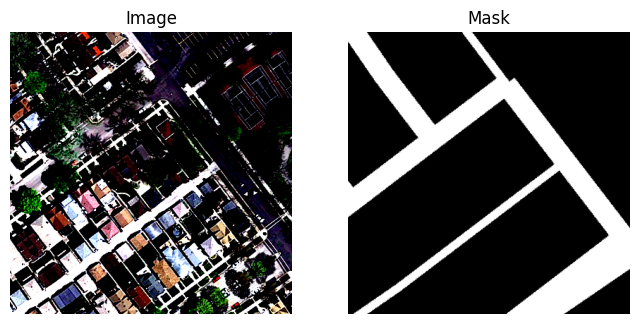

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 1-000 batch_loss=6.82e-01 batch_acc=0.701 batch_f1=0.119 lr=5.000e-04 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000213392CAD40>
Traceback (most recent call last):
  File "C:\Users\malou\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "C:\Users\malou\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\malou\anaconda3\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\malou\anaconda3\Lib\multiprocessing\popen_spawn_win32.py", line 109, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 
Epochs:   0%|          | 0/20 [00:41<?, ?it/s]


KeyboardInterrupt: 

In [56]:
#### Training loop ####

optimizer_kwargs = dict(
    lr=5e-4,
    weight_decay=1e-3,
)

num_epochs = 20 # best 200
n_channels = 3
n_classes = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_1 = UNet(n_channels,n_classes).to(device)
model_2 = MAResUNet(n_channels,n_classes).to("cpu")
# model_3 = PretrainedUNet(n_channels, n_classes,pretrained_backbone=True).to(device)

# model_factory = model_1 # -----> UNet
model_factory = model_2 # -----> MAResUNet
# model_factory = model_3 # -----> UNet Pretrained

data_kwargs = dict(
    batch_size=16,
    show_examples=True)

run_training(
    model_factory = model_factory,
    num_epochs = num_epochs,
    optimizer_kwargs = optimizer_kwargs,
    data_kwargs = data_kwargs,
    device = "cpu")